In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file
from threeML.io import update_logging_level
from threeML.utils.data_download.Fermi_LAT.download_LAT_data import LAT_dataset
from astropy.io import fits as pyfits

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# This if you want to toggle different type of logging level.
update_logging_level("INFO")
log.error("error")
log.info("info")
log.debug("debug")

06:20:47 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=768038;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=995616;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=472917;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=35543;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=677503;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=817624;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

06:20:49 ERROR     error                                                                           ]8;id=446655;file:///var/folders/hv/qqnln7cj5cg0n48fcrlmbz4m0000gn/T/ipykernel_51940/3699701126.py\3699701126.py]8;;\:]8;id=173931;file:///var/folders/hv/qqnln7cj5cg0n48fcrlmbz4m0000gn/T/ipykernel_51940/3699701126.py#29\29]8;;\

         INFO      info                                                                            ]8;id=783715;file:///var/folders/hv/qqnln7cj5cg0n48fcrlmbz4m0000gn/T/ipykernel_51940/3699701126.py\3699701126.py]8;;\:]8;id=491902;file:///var/folders/hv/qqnln7cj5cg0n48fcrlmbz4m0000gn/T/ipykernel_51940/3699701126.py#30\30]8;;\

## GtBurst
Gtburst contains all the classes and methods to perform Fermi LAT data. It internally uses the official fermitools software. Here an example to list the IRFS available:


In [2]:
from GtBurst import IRFS

irfs = IRFS.IRFS.keys()
print(irfs)

odict_keys(['p7rep_transient', 'p7rep_source', 'p7rep_clean', 'p7rep_ultraclean', 'p8r2_transient100e', 'p8r2_transient100', 'p8r2_transient020e', 'p8r2_transient020', 'p8r2_transient010e', 'p8r2_transient010', 'p8r2_source', 'p8r2_clean', 'p8r2_ultraclean', 'p8r2_ultracleanveto', 'p8r2_transient100s', 'p8r2_transient015s', 'p8_transient100e', 'p8_transient100', 'p8_transient020e', 'p8_transient020', 'p8_transient010e', 'p8_transient010', 'p8_source', 'p8_clean', 'p8_ultraclean', 'p8_ultracleanveto', 'p8_sourceveto', 'p8_transient100s', 'p8_transient015s'])


## The LAT Transient Builder
Let's see how to make a plug in for the unbinned analysis of Fermi LAT data. First we use the information form a triggered GRB to obtain MET, RA and DEC, that are needed for the analysis.


In [3]:
from GtBurst.TriggerSelector import TriggerSelector

myFavoriteGRB = "bn190114873"


def findGRB(grb_name):
    a = TriggerSelector()
    a.downloadList()
    myGRB = {}
    for x in a.data:
        if x[0] == myFavoriteGRB:
            myGRB["MET"] = float(x[1])
            myGRB["RA"] = float(x[3])
            myGRB["DEC"] = float(x[4])
            myGRB["ERR"] = float(x[5])
            return myGRB
            pass
    return None

In [4]:
myGRB = findGRB(myFavoriteGRB)
print(myGRB)

{'MET': 569192227.626, 'RA': 54.51, 'DEC': -26.939, 'ERR': 0.05}


Then, we download LAT data and we build the transient builder, we want to analyze 1000 seconds since the trigger. Let's start download the data:


In [5]:
tstart = 0
tstop = 1000

In [6]:
myLATdataset = LAT_dataset()

myLATdataset.make_LAT_dataset(
    ra=myGRB["RA"],
    dec=myGRB["DEC"],
    radius=12,
    trigger_time=myGRB["MET"],
    tstart=tstart,
    tstop=tstop,
    data_type="Extended",
    destination_directory=".",
    Emin=100.0,
    Emax=10000.0,
)  # Energies are MeV (this is from 100 MeV to 10 GeV)

06:21:01 INFO      Query parameters:                                                       ]8;id=373860;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=271583;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#262\262]8;;\

         INFO                          coordfield = 54.5100,-26.9390                       ]8;id=15026;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=378810;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         coordsystem = J2000                                  ]8;id=461240;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=900150;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          shapefield = 12                                     ]8;id=975257;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=68221;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                           timefield = 569192227.626,569193227.626            ]8;id=978966;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=898890;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                            timetype = MET                                    ]8;id=538589;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=368262;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         energyfield = 100.000,10000.000                      ]8;id=706320;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=646782;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO              photonOrExtendedOrNone = Extended                               ]8;id=519481;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=110780;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         destination = query                                  ]8;id=814178;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=913115;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          spacecraft = checked                                ]8;id=466134;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=792988;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO      Query ID: 86ad4d2b3b3e5065f0f0a976e6fc8315                              ]8;id=437105;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=393892;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#271\271]8;;\

         INFO      Estimated complete time for your query: 15 seconds                      ]8;id=573436;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=981116;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#428\428]8;;\

         INFO      If this download fails, you can find your data at                       ]8;id=634950;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=764595;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#437\437]8;;\
                  https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/QueryResults.cgi?id=L2405160                         
                  22103C0968AF258 (when ready)                                                                     

06:21:41 INFO      Downloading FT1 and FT2 files...                                        ]8;id=512983;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=853341;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#527\527]8;;\

06:21:47 WARNING   Only one FT1 file provided. Skipping the merge...                        ]8;id=870030;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=872208;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#98\98]8;;\

Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.rsp...
time -p gtselect infile=./bn190114873/gll_ft1_tr_bn190114873_v00.fit outfile=__temp_ft1.fits ra=54.51 dec=-26.939 rad=15.0 tmin=569192226.626 tmax=569193228.626 emin=10.0 emax=300000.0 zmin=0.0 zmax=110.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.13
user 0.09
sys 0.03
Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.pha...
 *  Get energy binning from the response matrix...

    done.

 *  Run gtbindef and gtbin and bin in energy and time...

time -p gtbindef bintype="E" binfile=__ebins.txt outfile=__energyBins.fits energyunits="keV" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbindef version HEAD
real 0.05
user 0.02
sys 0.01
time -p gtbin evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/__temp_ft1.fits scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=__gtllebin__pha2.pha algorithm="PHA2" ebinalg="FILE" emin=30.0 emax=200000.0 ebinfile=__energyBins.fits tbinalg="LIN" tstart=569192227.626 tstop=569193227.626 dtime=4.096 tbinfile=NONE coordsys="CEL" axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=1 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD


real 2.44
user 2.27
sys 0.14

    done.

 *  Transform gtbin output in CSPEC format...

    done.

 *  Updating keywords in the headers of the CSPEC file...

    done.

gtllebin done!


We want perform a time resolved analysis. So, first we look at the data. We can play with the ROI selection and the cut.


In [7]:
roi = 10
zmax = 110.0
thetamax = 180.0
irfs = "p8_transient020e"
strategy = "time"
myLATdataset.extract_events(roi, zmax, irfs, thetamax, strategy="time")

time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit evtable="EVENTS" outfile="gll_ft1_tr_bn190114873_v00_mkt.fit" apply_filter=yes overwrite=no header_obstimes=yes tstart=569192227.626 tstop=569193227.626 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"


real 0.09
user 0.06
sys 0.02

Using 305 data

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192227.626 tmax=569193227.626 emin=100.0 emax=10000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"


Done.
real 0.11
user 0.09
sys 0.02

Selected 251 events.


06:21:50 INFO      Extracted 251 events                                                    ]8;id=476390;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=302999;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#670\670]8;;\

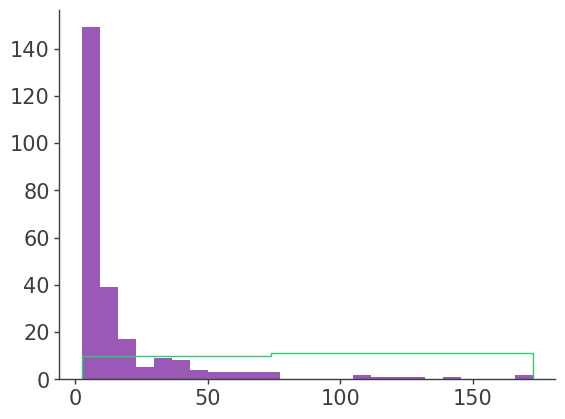

In [8]:
%matplotlib inline
event_file = pyfits.open(myLATdataset.filt_file)
event_times = sorted(event_file["EVENTS"].data["TIME"] - myGRB["MET"])
intervals = event_times[0::10]
_ = plt.hist(event_times)
_ = plt.hist(event_times, intervals, histtype="step")
# plt.show()

tstarts and tstops are defined as strings, with somma separated values for the starts and the ends of the time bins: For example tsrats="0,1,10" and tstops="1,10,20". To convert arrays in string we use these few lines of code:


In [9]:
tstarts = tstops = ""
for t0, t1 in zip(intervals[:-1], intervals[1:]):
    tstarts += "%.4f," % t0
    tstops += "%.4f," % t1
    pass
tstarts = tstarts[:-1].replace("-", "\\-")
tstops = tstops[:-1].replace("-", "\\-")

We can now make an instance the LAT transient builder


In [10]:
analysis_builder = TransientLATDataBuilder(
    myLATdataset.grb_name,
    outfile=myLATdataset.grb_name,
    roi=roi,
    tstarts=tstarts,
    tstops=tstops,
    irf=irfs,
    zmax=zmax,
    galactic_model="template",
    particle_model="isotr template",
    datarepository=".",
)
df = analysis_builder.display(get=True)

outfile                                                       190114873
roi                                                                  10
tstarts               2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.54...
tstops                3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.98...
zmax                                                              110.0
emin                                                              100.0
emax                                                           100000.0
irf                                                    p8_transient020e
galactic_model                                                 template
particle_model                                           isotr template
source_model                                                  PowerLaw2
tsmin                                                              20.0
strategy                                                           time
thetamax                                                        

In [11]:
tstops

'3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754'

The run method will run (using gtburst) all the fermitools needed to obtain the needed file for the likelihood analysis (livetimecubes, exposure maps. It will also perfom a simple likelihood analysis with the standard likelihood of the fermitools (pylikelihood). The dataproducts created here will be used by threeML to make the fit.


In [12]:
LAT_observations = analysis_builder.run(include_previous_intervals=True)

06:21:51 INFO      Changing permission to                                              ]8;id=579447;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=783657;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py                                                      

         INFO      Changing permission to                                              ]8;id=51669;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=69607;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtdiffrsp_mp.py                                                          

         INFO      Changing permission to                                              ]8;id=167858;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=357022;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtexpmap_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=647874;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=161406;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtltcube_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=518321;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=579248;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gttsmap_mp.py                                                            

         INFO      About to run the following command:                                 ]8;id=907718;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=947877;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#640\640]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py 190114873 --outfile                                  
                  '190114873' --roi 10.000000 --tstarts                                                            
                  '2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.68                             
                  89,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165                             
                  ,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262' --tstops                                       
                  '3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.01                             
                  17,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.783                             
                  4,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754' --zmax                                       
                  110.000000 --emin 100.000000 --emax 100000.000000 --irf                                          
                  'p8_transient020e' --galactic_model 'template' --particle_model                                  
                  'isotr template' --source_model 'PowerLaw2' --tsmin 20.000000                                    
                  --strategy 'time' --thetamax 180.000000 --spectralfiles 'no'                                     
                  --liketype 'unbinned' --optimizeposition 'no' --datarepository '.'                               
                  --ltcube '' --expomap '' --ulphindex -2.000000 --flemin 100.000000                               
                  --flemax 10000.000000 --fgl_mode 'fast'                                                          

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   25.19240     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .29E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.71579     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .58E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Requested intervals:
------------------------------------------------------
2.6996               - 3.6358
3.6358               - 3.9968
3.9968               - 4.4024
4.4024               - 4.7375
4.7375               - 5.0909
5.0909               - 5.5471
5.5471               - 5.9896
5.9896               - 6.3998
6.3998               - 6.6889
6.6889               - 7.0117
7.0117               - 7.2936
7.2936               - 7.7731
7.7731               - 8.2167
8.2167               - 8.8763
8.8763               - 9.6573
9.6573               - 10.568
10.568               - 12.0568
12.0568              - 14.6165
14.6165              - 17.7834
17.7834              - 21.4962
21.4962              - 30.0798
30.0798              - 40.8747
40.8747              - 48.7118
48.7118              - 73.7262
73.7262              - 172.5754

Data files:
-----------
eventfile            /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit
ft2file      

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   4.786573     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   5.901543     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .70E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtexpmap_mp.py 40 40 2 2 /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit gll_ft1_tr_bn190114873_v00_filt_ltcube.fit P8R3_TRANSIENT020E_V3 20.0 20 gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Starting calculation of region 0.0,20.0 to 20.0,40.0

Completed calculation of region 0.0,20.0 to 20.0,40.0

Starting calculation of region 20.0,20.0 to 40.0,40.0

Completed calculation of region 20.0,20.0 to 40.0,40.0

Starting calculation of region 0.0,0.0 to 20.0,20.0

Completed calculation of region 0.0,0.0 to 20.0,20.0

Starting calculation of region 20.0,0.0 to 40.0,20.0

Completed calculation of region 20.0,0.0 to 40.0,20.0

Spawning 4 jobs...

Combining temporary files...

Deleting temporary files...



time -p gtdiffrsp evfile=/

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.43105     FROM MIGRAD    STATUS=CONVERGED     67 CALLS       68 TOTAL
                     EDM=   .19E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192232.0284001 tmax=569192232.3635 emin=100.0 emax=100000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.11
user 0.09
sys 0.01

Selected 10 events.
time -p gtbin evfile=gll_ft1_tr_bn190114873_v00_filt.fit scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=190114873_LAT_skymap_4.4024-4.7375.fit algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=101 nypix=101 binsz=0.2 coordsys="CEL" xref=54.51 yref=-26.939 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no 

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   11.37565     FROM MIGRAD    STATUS=CONVERGED     74 CALLS       75 TOTAL
                     EDM=   .16E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  9.4%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   7.632503     FROM MIGRAD    STATUS=CONVERGED     61 CALLS       62 TOTAL
                     EDM=   .99E-06  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  5.3%

  EXT PARAMETER                            

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   145|
|                    |       Integral|    0.0202|     0.00667| ph./cm2/s|      |
|                    |          Index|     -2.16|       0.362|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|  1.23e-05|    5.57e-06| erg/cm2/s|      |
|                    |    Photon flux|    0.0201|     0.00668| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     0|
|                    |          Value|         1|        0.15|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   10.79486     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .15E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   6.844639     FROM MIGRAD    STATUS=CONVERGED     66 CALLS       67 TOTAL
                     EDM=   .31E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_5.5471-5.9896.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_5.5471-5.9896.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval5.5471-5.9896/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.59
user 0.29
sys 0.28
/usr/lo

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   8.317516     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .68E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_6.3998-6.6889.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='6.3998' tstop='6.6889' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   12.58093     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .10E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   18.30164     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.6889-7.0117/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_6.6889-7.0117.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.6889-7.0117/gll_ft1_tr_bn190114873_v00_filt.fit.........!
real 6.40
user 5.76
sys 0.53
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   14.90094     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .44E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtbin evfile=gll_ft1_tr_bn190114873_v00_filt.fit scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=190114873_LAT_skymap_7.2936-7.7731.fit algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=101 nypix=101 binsz=0.2 coordsys="CEL" xref=54.51 yref=-26.939 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
real 0.15
user 0.13
sys 0.02

Total number of events in the counts map: 10
Total time in Good Time Intervals:        0.47950005531311035
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_7.2936-7.7731.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast'

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   13.18701     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .24E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.5%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   24.59086     FROM MIGRAD    STATUS=CONVERGED     57 CALLS       58 TOTAL
                     EDM=   .13E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   128|
|                    |       Integral|     0.018|     0.00597| ph./cm2/s|      |
|                    |          Index|     -2.62|       0.447|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|  7.11e-06|    2.74e-06| erg/cm2/s|      |
|                    |    Photon flux|     0.018|     0.00597| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     1|
|                    |          Value|         1|       0.134|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   28.24928     FROM MIGRAD    STATUS=CONVERGED     56 CALLS       57 TOTAL
                     EDM=   .18E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   29.59265     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .12E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_8.8763-9.6573.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_8.8763-9.6573.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval8.8763-9.6573/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.68
user 0.34
sys 0.30
/usr/lo

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   30.55516     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .11E-04  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.1%

  EXT PARAMETER                            

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_10.568-12.0568.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='10.568' tstop='12.0568' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn19011487

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   29.31981     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .64E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  3.9%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   38.58473     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .91E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  4.2%

  EXT PARAMETER                            

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval12.0568-14.6165/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_12.0568-14.6165.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval12.0568-14.6165/gll_ft1_tr_bn190114873_v00_filt.fit.........!
real 6.73
user 6.22
sys 0.50
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/th

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   41.85635     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .15E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtbin evfile=gll_ft1_tr_bn190114873_v00_filt.fit scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=190114873_LAT_skymap_17.7834-21.4962.fit algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=101 nypix=101 binsz=0.2 coordsys="CEL" xref=54.51 yref=-26.939 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
real 0.16
user 0.13
sys 0.02

Total number of events in the counts map: 11
Total time in Good Time Intervals:        3.712799906730652
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_17.7834-21.4962.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fas

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   40.63160     FROM MIGRAD    STATUS=CONVERGED     71 CALLS       72 TOTAL
                     EDM=   .94E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   34.58971     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .11E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   119|
|                    |       Integral|  0.000725|     0.00023| ph./cm2/s|      |
|                    |          Index|     -1.42|       0.272|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|   1.2e-06|    5.71e-07| erg/cm2/s|      |
|                    |    Photon flux|  0.000656|    0.000215| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     0|
|                    |          Value|         1|        0.15|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   51.56070     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   66.71287     FROM MIGRAD    STATUS=CONVERGED     64 CALLS       65 TOTAL
                     EDM=   .42E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_40.8747-48.7118.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_40.8747-48.7118.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval40.8747-48.7118/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.86
user 0.32
sys 0.35
/

time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit evtable="EVENTS" outfile="gll_ft1_tr_bn190114873_v00_mkt.fit" apply_filter=yes overwrite=no header_obstimes=yes tstart=569192301.3522 tstop=569192400.2014 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 0.13
user 0.08
sys 0.03

Using 305 data

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192301.3522 tmax=569192400.2014 emin=100.0 emax=100000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=

06:35:20 INFO      The ft2 file does not exist. Please examine!                        ]8;id=922278;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=564181;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=733166;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=791799;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=863836;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=875559;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval10.568-12.0568/gll_ft2_tr_bn190114873_v00.fit                                            

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=28290;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=298670;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=768133;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=658273;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=762752;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=682522;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval12.0568-14.6165/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=482861;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=618993;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=873111;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=704197;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=468163;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=872701;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval14.6165-17.7834/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=279147;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=243998;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=355466;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=141692;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=262970;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=918767;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval17.7834-21.4962/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=45696;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=391828;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=525407;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=410424;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=902159;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=940066;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval2.6996-3.6358/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=525740;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=542581;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=335457;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=837812;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=453010;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=709965;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval21.4962-30.0798/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=283552;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=977099;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=484973;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=152239;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=382440;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=442648;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval3.6358-3.9968/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=552451;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=445825;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=473982;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=16255;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=227189;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=789236;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval3.9968-4.4024/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=206097;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=833012;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=920787;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=330622;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=28452;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=204887;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval30.0798-40.8747/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=968726;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=513926;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=977054;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=863625;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=59221;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=741522;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval4.4024-4.7375/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=935791;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=829535;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=578619;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=51630;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=666136;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=799120;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval4.7375-5.0909/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=585533;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=703852;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=945046;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=971411;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=13151;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=352752;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval40.8747-48.7118/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=663630;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=815192;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=941909;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=816863;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=568475;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=708701;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval48.7118-73.7262/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=3786;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=693876;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=68569;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=2707;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=708242;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=370090;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.0909-5.5471/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=269174;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=51961;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=397570;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=388380;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=102314;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=183628;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.5471-5.9896/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=40409;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=586147;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=39084;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=411172;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=118271;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=618176;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.9896-6.3998/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=867880;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=723612;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=542445;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=554102;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=299031;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=340096;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval6.3998-6.6889/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=530157;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=123286;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=998981;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=719111;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=160246;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=495780;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval6.6889-7.0117/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=526576;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=266016;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=368844;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=914318;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=937437;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=593576;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.0117-7.2936/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=137216;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=461716;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=677558;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=524268;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=226790;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=470036;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.2936-7.7731/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=646465;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=757901;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=668229;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=19252;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=166258;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=78247;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.7731-8.2167/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=911028;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=575458;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=407088;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=807402;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=385316;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=927150;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval73.7262-172.5754/gll_ft2_tr_bn190114873_v00.fit                                          

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=935661;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=748076;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=982455;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=892121;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=93968;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=525636;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval8.2167-8.8763/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=75859;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=73947;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=731330;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=422389;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=960730;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=188136;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval8.8763-9.6573/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=201205;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=413985;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=146378;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=33816;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=851448;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=623212;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval9.6573-10.568/gll_ft2_tr_bn190114873_v00.fit                                             

 At this point we can create the FermiLATLike plugins from each of the observation:

In [13]:
LAT_plugins = {}
for l in LAT_observations:
    LAT_name = "LAT_%06.3f-%06.3f" % (float(l.tstart), float(l.tstop))
    LAT_plugins[LAT_name] = l.to_LATLike()
    pass

FermiLATLike - GTI SUM =  1.488800048828125
FermiLATLike - GTI SUM =  2.5597000122070312


FermiLATLike - GTI SUM =  3.1669000387191772


FermiLATLike - GTI SUM =  3.712799906730652
FermiLATLike - GTI SUM =  0.9362000226974487


FermiLATLike - GTI SUM =  8.583600044250488
FermiLATLike - GTI SUM =  0.3609999418258667


FermiLATLike - GTI SUM =  0.40560007095336914
FermiLATLike - GTI SUM =  10.794899940490723


FermiLATLike - GTI SUM =  0.3350999355316162
FermiLATLike - GTI SUM =  0.35339999198913574


FermiLATLike - GTI SUM =  7.837100028991699
FermiLATLike - GTI SUM =  25.014400005340576


FermiLATLike - GTI SUM =  0.4562000036239624
FermiLATLike - GTI SUM =  0.4424999952316284


FermiLATLike - GTI SUM =  0.41019999980926514
FermiLATLike - GTI SUM =  0.2891000509262085


FermiLATLike - GTI SUM =  0.32280004024505615


FermiLATLike - GTI SUM =  0.28189992904663086


FermiLATLike - GTI SUM =  0.47950005531311035


FermiLATLike - GTI SUM =  0.4435999393463135
FermiLATLike - GTI SUM =  98.84920001029968


FermiLATLike - GTI SUM =  0.659600019454956
FermiLATLike - GTI SUM =  0.781000018119812


FermiLATLike - GTI SUM =  0.9106999635696411


For reference, these are the keys save in the dictionary.


In [14]:
LAT_plugins.keys()

dict_keys(['LAT_10.568-12.057', 'LAT_12.057-14.617', 'LAT_14.617-17.783', 'LAT_17.783-21.496', 'LAT_02.700-03.636', 'LAT_21.496-30.080', 'LAT_03.636-03.997', 'LAT_03.997-04.402', 'LAT_30.080-40.875', 'LAT_04.402-04.737', 'LAT_04.737-05.091', 'LAT_40.875-48.712', 'LAT_48.712-73.726', 'LAT_05.091-05.547', 'LAT_05.547-05.990', 'LAT_05.990-06.400', 'LAT_06.400-06.689', 'LAT_06.689-07.012', 'LAT_07.012-07.294', 'LAT_07.294-07.773', 'LAT_07.773-08.217', 'LAT_73.726-172.575', 'LAT_08.217-08.876', 'LAT_08.876-09.657', 'LAT_09.657-10.568'])

Now we can perform the fit in each bin. Note that we set the model, and we set some initial values. All the resulting joint likelihood objects are stored in a dictioonary to be used later for plotting.


In [15]:
results = {}
update_logging_level("DEBUG")

for T0, T1 in zip(intervals[:-1], intervals[1:]):
    GRB = PointSource(
        "GRB", ra=myGRB["RA"], dec=myGRB["DEC"], spectral_shape=Powerlaw_flux()
    )
    model = Model(GRB)
    model.GRB.spectrum.main.Powerlaw_flux.a = 100.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.b = 10000.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.F = 1.0
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    LAT_model_name = ("LAT%dX%d" % (T0, T1)).replace("-", "n")
    datalist = DataList(LAT_plugins[LAT_name])
    model["GRB.spectrum.main.Powerlaw_flux.F"].bounds = (1e-6, 1e6)
    model["GRB.spectrum.main.Powerlaw_flux.F"].value = 1e-2
    model["GRB.spectrum.main.Powerlaw_flux.index"].value = -2.2
    model["GRB.spectrum.main.Powerlaw_flux.index"].bounds = (-3, 0)
    jl = JointLikelihood(model, datalist, verbose=False)
    model[LAT_model_name + "_GalacticTemplate_Value"].value = 1.0
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    # model.display( complete=True )
    jl.set_minimizer("minuit")
    jl.fit(compute_covariance=True)
    results[LAT_name] = jl
    pass

06:35:29 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=470496;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=293048;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

06:35:29 DEBUG     creating new MLE analysis                                                 ]8;id=640011;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=820093;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=213252;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=768001;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:35:38 DEBUG     Removing non-needed files                                                    ]8;id=249356;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=144490;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=910771;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=374803;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=602348;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=105254;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=454320;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=361936;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=376991;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=914517;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=178679;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=26246;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=740490;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=965486;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=174187;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=849272;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=257533;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332013;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=551383;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=534507;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.035850408347845                       ]8;id=996153;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=40544;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.999991708177062                   ]8;id=635693;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=395867;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT2X3_IsotropicTemplate_Normalization = 4.9998262064715675                  ]8;id=330419;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=800060;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=832690;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=600304;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   75.02 percent of samples have been thrown away because they failed the  ]8;id=293546;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=733908;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(9.2 -2.5 +3.4) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0033,
LAT2X3_IsotropicTemplate_Normalization,5.0 +/- 0.4,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT2X3,40.664992
total,40.664992


Values of statistical measures:

,statistical measures
AIC,91.329983
BIC,88.237739


06:35:39 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=91170;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=747044;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

06:35:39 DEBUG     creating new MLE analysis                                                 ]8;id=168510;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=329435;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=470098;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=41316;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:35:45 DEBUG     Removing non-needed files                                                    ]8;id=726503;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=146092;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

06:35:46 DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=957449;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=855038;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=505433;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=371208;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=768187;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=764704;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=55496;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138176;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=31791;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=209772;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=178472;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=455275;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=225314;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=717085;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=919854;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=892008;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=378482;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=106197;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6218053649739153                      ]8;id=902273;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=920751;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9999932121176722                  ]8;id=120144;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=696699;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X3_IsotropicTemplate_Normalization = 4.997384151781968                   ]8;id=429463;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=145034;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=987827;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=838822;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   75.56 percent of samples have been thrown away because they failed the  ]8;id=175923;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=157927;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.4 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0026,
LAT3X3_IsotropicTemplate_Normalization,5.0 +/- 1.5,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,-0.00
-0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X3,29.516899
total,29.516899


Values of statistical measures:

,statistical measures
AIC,69.033798
BIC,65.941553


06:35:46 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=738704;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=918203;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=597515;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=322504;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=15113;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=705637;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:35:52 DEBUG     Removing non-needed files                                                    ]8;id=84119;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=940762;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=760135;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=918478;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=480322;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=614106;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=603250;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=350234;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=814696;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=827142;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=555098;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=140948;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

06:35:53 INFO      set the minimizer to MINUIT                                             ]8;id=320959;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=568677;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=332882;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=869499;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=863291;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=23864;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=401523;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=661657;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6739857264716593                      ]8;id=959802;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=417205;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9704822069906327                  ]8;id=863857;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=844987;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X4_IsotropicTemplate_Normalization = 0.10022644625362875                 ]8;id=804417;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=277010;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=145891;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=225123;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   74.08 percent of samples have been thrown away because they failed the  ]8;id=321685;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=903403;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.1 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0 +/- 0.5,
LAT3X4_IsotropicTemplate_Normalization,(1 +/- 9) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X4,19.890361
total,19.890361


Values of statistical measures:

,statistical measures
AIC,49.780722
BIC,46.688478


06:35:53 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=530512;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=938577;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=68793;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=595642;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=444493;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=622241;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:00 DEBUG     Removing non-needed files                                                    ]8;id=980600;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=839019;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=783812;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=290028;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=72280;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=503208;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=214163;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=412414;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=648229;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=916211;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=739789;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=415802;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=7524;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=463762;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=937635;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=49188;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=864455;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=351429;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=20064;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=234916;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355708839216427                      ]8;id=505170;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=201932;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.492533539531339                   ]8;id=20771;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=12130;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X4_IsotropicTemplate_Normalization = 0.10000066202558072                 ]8;id=563148;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=376948;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=428910;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=667289;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   55.22 percent of samples have been thrown away because they failed the  ]8;id=866717;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=133542;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


06:36:00 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=149561;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=47967;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=83635;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=917095;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=422010;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=580988;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:07 DEBUG     Removing non-needed files                                                    ]8;id=699174;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=49998;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=100320;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=436520;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=405457;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=906796;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=952306;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=532269;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=606350;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=193574;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=438923;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=333492;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=476031;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=312416;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=350266;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=732027;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=21133;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=189885;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=752552;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=488052;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.69751554407834                        ]8;id=210099;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=409245;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1555843829138626                  ]8;id=922661;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=864491;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X5_IsotropicTemplate_Normalization = 0.10002834867420268                 ]8;id=462546;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=745830;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=45417;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=679008;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.03999999999999 percent of samples have been thrown away because they ]8;id=605927;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=801077;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT4X5_IsotropicTemplate_Normalization,(1.0 +/- 3.0) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X5,28.534664
total,28.534664


Values of statistical measures:

,statistical measures
AIC,67.069327
BIC,63.977083


06:36:07 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=795967;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=630137;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=172606;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=535446;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=842221;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=244167;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:14 DEBUG     Removing non-needed files                                                    ]8;id=629297;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=360663;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=430328;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=297334;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=757741;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=165213;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=521083;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=705784;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=395931;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=265592;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=704447;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=864546;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=642568;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=983901;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=629207;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=147514;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=835959;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=125007;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=250270;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=623969;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9619951685801957                      ]8;id=2633;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=423253;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.357787396251045                   ]8;id=271741;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=106059;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10007214359718819                 ]8;id=461756;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=116381;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=981183;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=259815;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.8 percent of samples have been thrown away because they failed the   ]8;id=296519;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=861513;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.09 -0.32 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.36 +/- 0.28,
LAT5X5_IsotropicTemplate_Normalization,(1 +/- 5) x 10^-1,


Correlation matrix:

1.00,-0.25,-0.00
-0.25,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,24.177478
total,24.177478


Values of statistical measures:

,statistical measures
AIC,59.154956
BIC,54.946630


06:36:14 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=341804;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=594081;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=473134;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=309998;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=836336;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=113880;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:20 DEBUG     Removing non-needed files                                                    ]8;id=879657;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=227314;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=476244;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=356225;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=823728;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=286778;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=76635;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=187556;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=902124;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318663;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=422847;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=616018;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

06:36:21 INFO      set the minimizer to MINUIT                                             ]8;id=176097;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332332;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=395410;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=455119;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=826856;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=210329;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=890145;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=715970;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7988559367529733                      ]8;id=951021;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=370199;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1236975151251234                  ]8;id=494093;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=776074;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10278726281245283                 ]8;id=359950;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=174284;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=662389;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=597852;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   52.6 percent of samples have been thrown away because they failed the   ]8;id=444372;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=862562;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.6 -0.4 +0.6) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.1 +/- 0.4,
LAT5X5_IsotropicTemplate_Normalization,0.1 +/- 2.4,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,22.736916
total,22.736916


Values of statistical measures:

,statistical measures
AIC,55.473833
BIC,52.381588


06:36:21 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=143206;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=107898;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=924708;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=183471;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=560576;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=381977;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:27 DEBUG     Removing non-needed files                                                    ]8;id=455720;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=204822;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=788443;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=423287;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=975514;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=481782;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=713258;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=135653;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=51881;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=765727;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=672488;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=378139;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=264068;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=147860;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=93330;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11967;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=914902;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=758773;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

06:36:28 DEBUG     Restoring best fit:                                                          ]8;id=487833;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=725058;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7207597084097388                      ]8;id=586030;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=641839;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.5179188763814526                  ]8;id=53231;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=295069;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X6_IsotropicTemplate_Normalization = 0.10000056537138591                 ]8;id=91693;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=28908;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=868748;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=743873;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   55.300000000000004 percent of samples have been thrown away because     ]8;id=608532;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=902746;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.9 -0.5 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT5X6_IsotropicTemplate_Normalization,(1.0 +/- 0.5) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X6,25.898652
total,25.898652


Values of statistical measures:

,statistical measures
AIC,61.797305
BIC,58.705060


06:36:28 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=395930;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=839032;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=753300;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=1970;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=60889;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=537063;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:34 DEBUG     Removing non-needed files                                                    ]8;id=272353;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=698505;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=786855;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=283617;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=762707;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=463651;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=978636;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=578369;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=561032;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=394637;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=725629;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=458097;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=62685;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=723868;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=708678;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=767733;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

06:36:35 DEBUG     starting local optimization                                              ]8;id=818282;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=312506;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=872004;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=624763;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.5964520921915943                      ]8;id=235498;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=704961;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.9399187221889842                  ]8;id=681358;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=286856;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X6_IsotropicTemplate_Normalization = 0.10000980163931177                 ]8;id=728215;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=642391;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=551938;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=40075;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.94 percent of samples have been thrown away because they failed the  ]8;id=411343;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=694971;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.5 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.94 +/- 0.31,
LAT6X6_IsotropicTemplate_Normalization,(1.0 +/- 2.1) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X6,24.346796
total,24.346796


Values of statistical measures:

,statistical measures
AIC,58.122163
BIC,55.887278


06:36:35 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=594046;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=496218;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=746111;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=355006;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=35125;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=731197;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:41 DEBUG     Removing non-needed files                                                    ]8;id=699741;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=433364;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=233839;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=463285;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=57458;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=360447;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=176231;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=419212;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=12517;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=762625;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=166602;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=972549;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=65174;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=757990;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=366965;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=912363;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=451127;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=265786;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

06:36:42 DEBUG     Restoring best fit:                                                          ]8;id=141519;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=779812;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6921001026063185                      ]8;id=498875;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=968584;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.2578600601426784                  ]8;id=154987;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=909272;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X7_IsotropicTemplate_Normalization = 4.971986892239891                   ]8;id=575558;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=824949;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=444525;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=525615;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   89.02 percent of samples have been thrown away because they failed the  ]8;id=774270;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=672831;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.3 +/- 0.4,
LAT6X7_IsotropicTemplate_Normalization,(0.5 +/- 1.8) x 10,


Correlation matrix:

1.00,-0.31,-0.01
-0.31,1.00,0.01
-0.01,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X7,21.118623
total,21.118623


Values of statistical measures:

,statistical measures
AIC,53.037245
BIC,48.828919


06:36:42 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=743845;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=565545;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=565126;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714905;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=587906;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=176208;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:48 DEBUG     Removing non-needed files                                                    ]8;id=89046;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=393980;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=151998;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=502575;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=31468;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=106441;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=876744;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=799428;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=888929;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=756058;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=488415;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=706534;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=666825;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=54570;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

06:36:49 DEBUG     beginning the fit!                                                       ]8;id=592762;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=181875;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=114885;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=380237;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=589906;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=397415;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355267962096465                      ]8;id=870307;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=883512;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8761370498083396                  ]8;id=499472;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=699887;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.10005170951183916                 ]8;id=794987;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=843399;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=974753;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=141093;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.2 percent of samples have been thrown away because they failed the   ]8;id=807732;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=592895;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.88 +/- 0.32,
LAT7X7_IsotropicTemplate_Normalization,(1 +/- 4) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,27.684882
total,27.684882


Values of statistical measures:

,statistical measures
AIC,65.369764
BIC,62.277519


06:36:49 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=313837;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=503321;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=374236;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=47905;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=648781;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=551755;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:36:56 DEBUG     Removing non-needed files                                                    ]8;id=275608;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=104577;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=134133;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=138387;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=602764;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=677740;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=605323;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=463679;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=172601;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850157;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=191622;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=329479;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=392872;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=608621;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=466657;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=813428;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=400896;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=357732;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=34823;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=934127;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.874407444120822                       ]8;id=843590;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=847560;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8167269261282395                  ]8;id=439656;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=919925;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.101118521519397                   ]8;id=66572;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=337981;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=473470;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=23520;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.63999999999999 percent of samples have been thrown away because they ]8;id=960862;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=462754;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.3 -0.4 +0.5) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.82 +/- 0.31,
LAT7X7_IsotropicTemplate_Normalization,0.1 +/- 1.7,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,33.405978
total,33.405978


Values of statistical measures:

,statistical measures
AIC,76.811955
BIC,73.719711


06:36:56 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=199472;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=777183;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=421041;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=458642;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=150117;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=743833;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:03 DEBUG     Removing non-needed files                                                    ]8;id=669957;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=242276;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=293603;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=452967;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=97114;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=547965;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=385129;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=939463;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=433509;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=560043;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=68203;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=256047;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=407531;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=113498;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=699948;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=805215;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=293798;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=375279;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=353731;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=469530;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.745332153348909                       ]8;id=899374;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=280194;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.615089775519224                   ]8;id=646481;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=776505;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X8_IsotropicTemplate_Normalization = 4.9984007089917                     ]8;id=919050;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=901682;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=541366;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=884785;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   59.040000000000006 percent of samples have been thrown away because     ]8;id=340606;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=469151;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.6 +/- 0.5,
LAT7X8_IsotropicTemplate_Normalization,5.0 +/- 1.2,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X8,29.99633
total,29.99633


Values of statistical measures:

,statistical measures
AIC,69.992660
BIC,66.900416


06:37:03 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=425147;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=982969;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=522387;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=544750;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=931545;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=811147;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:10 DEBUG     Removing non-needed files                                                    ]8;id=548095;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=158214;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=467779;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=148805;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=812294;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=961842;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=632285;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=722778;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=532854;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=383760;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=871873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=122748;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=841971;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=891336;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=370558;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=818878;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=754989;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=635365;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=659226;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=283242;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.966919994271686                       ]8;id=262900;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=945898;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.167684025524464                   ]8;id=248765;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=739765;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X8_IsotropicTemplate_Normalization = 0.10024120943558205                 ]8;id=458593;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=373112;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=240852;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=689551;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.68 percent of samples have been thrown away because they failed the  ]8;id=6743;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=165864;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.08 -0.31 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT8X8_IsotropicTemplate_Normalization,(1 +/- 8) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X8,28.291424
total,28.291424


Values of statistical measures:

,statistical measures
AIC,66.582848
BIC,63.490603


06:37:10 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=438495;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=876189;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=134833;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=261637;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=263616;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=373434;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:17 DEBUG     Removing non-needed files                                                    ]8;id=368786;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=859913;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=660431;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=17773;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=420573;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=756187;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=659789;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=906668;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=549648;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=82156;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=861650;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=891953;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=967903;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=125037;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=607133;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=859615;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=862354;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=261924;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=959999;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=527937;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9989307667694747                      ]8;id=565303;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=412123;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1742660371809626                  ]8;id=225729;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=314980;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X9_IsotropicTemplate_Normalization = 4.999904165040313                   ]8;id=25698;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=856609;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=348198;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=747189;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.62 percent of samples have been thrown away because they failed the  ]8;id=561430;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=407874;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.00 -0.27 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.17 +/- 0.35,
LAT8X9_IsotropicTemplate_Normalization,5.00 +/- 0.27,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X9,42.084703
total,42.084703


Values of statistical measures:

,statistical measures
AIC,93.597977
BIC,91.363091


06:37:17 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=568283;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=319143;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=354118;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=564708;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=391218;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=220368;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:24 DEBUG     Removing non-needed files                                                    ]8;id=45893;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=524562;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=746741;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=250033;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=383105;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=296794;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=205714;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=496072;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=141925;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851655;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=377783;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=419001;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=104570;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=3520;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=216468;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=388144;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=860666;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=420509;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=895842;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=301759;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.1682899419752197                      ]8;id=503827;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=175611;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7278761567405359                  ]8;id=618301;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=255829;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT9X10_IsotropicTemplate_Normalization = 4.999974002396179                  ]8;id=453524;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=366325;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=700254;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=689782;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.88 percent of samples have been thrown away because they failed the  ]8;id=588947;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=90158;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.8 -1.9 +2.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.73 +/- 0.30,
LAT9X10_IsotropicTemplate_Normalization,5.00 +/- 0.07,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT9X10,43.319201
total,43.319201


Values of statistical measures:

,statistical measures
AIC,96.638402
BIC,93.546158


06:37:24 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=317545;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=481662;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=377115;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=264595;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=658093;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=566577;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:32 DEBUG     Removing non-needed files                                                    ]8;id=441876;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=701444;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=674273;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=838846;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=824657;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=285000;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=170169;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=909395;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=666869;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=560873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=401594;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=367871;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=420641;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=864149;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=63650;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=141544;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=270100;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=552621;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=984438;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=748352;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.4181766100254074                      ]8;id=62624;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=719274;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4634240053704302                  ]8;id=133922;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=223493;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT10X12_IsotropicTemplate_Normalization = 4.9999925794176905                ]8;id=388840;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=358635;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=661622;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=914845;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.260000000000005 percent of samples have been thrown away because     ]8;id=787131;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=496673;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.8 -1.1 +1.5) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.46 +/- 0.28,
LAT10X12_IsotropicTemplate_Normalization,5.00 +/- 0.05,


Correlation matrix:

1.00,-0.27,0.00
-0.27,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT10X12,44.676283
total,44.676283


Values of statistical measures:

,statistical measures
AIC,99.352567
BIC,96.260322


06:37:32 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=187007;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=261161;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=979779;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=689161;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=841851;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=300948;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:39 DEBUG     Removing non-needed files                                                    ]8;id=330078;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=314641;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=614035;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=970981;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=876797;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=299888;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=667989;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=901646;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=353097;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=465447;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=444157;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=436889;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=985036;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167827;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=678259;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=584180;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=383111;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=830012;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=12739;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=73768;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.5666975566847854                      ]8;id=614885;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=915716;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.4716815853065044                  ]8;id=439796;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=976161;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT12X14_IsotropicTemplate_Normalization = 0.10000005244652592               ]8;id=76076;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=494355;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=480622;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=499424;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   55.17999999999999 percent of samples have been thrown away because they ]8;id=824413;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=246082;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.7 -0.8 +1.1) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT12X14_IsotropicTemplate_Normalization,(1.00 +/- 0.07) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT12X14,43.35698
total,43.35698


Values of statistical measures:

,statistical measures
AIC,97.513960
BIC,93.305634


06:37:39 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=312448;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=733020;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=606856;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=241997;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=509003;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=80268;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:46 DEBUG     Removing non-needed files                                                    ]8;id=25800;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=906410;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=197902;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=97315;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=674103;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=294988;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=297345;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=52652;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=134504;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=175465;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=46112;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=935462;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=128009;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=726631;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=550;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=455368;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=215779;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=844434;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=960809;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=924871;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.699064502270993                       ]8;id=890711;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=437433;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7831868025545965                  ]8;id=66918;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=927914;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT14X17_IsotropicTemplate_Normalization = 0.10001890630551728               ]8;id=533840;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=963972;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=589805;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=483500;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.68 percent of samples have been thrown away because they failed the  ]8;id=477684;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=977243;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.78 +/- 0.31,
LAT14X17_IsotropicTemplate_Normalization,(1.0 +/- 1.1) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT14X17,44.424215
total,44.424215


Values of statistical measures:

,statistical measures
AIC,98.848429
BIC,95.756184


06:37:46 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=705226;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=992743;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=120370;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=874080;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=777100;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=492144;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:37:53 DEBUG     Removing non-needed files                                                    ]8;id=667310;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=350246;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=632374;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=932652;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=254387;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=158347;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=162645;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=119580;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=523060;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=433210;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=975440;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=615004;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=706287;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=481759;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=392206;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=662371;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=66758;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=492557;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=120488;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=435075;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.735356921067409                       ]8;id=330435;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=824528;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.72394312547533                    ]8;id=23145;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=951379;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT17X21_IsotropicTemplate_Normalization = 0.10724605578727957               ]8;id=562350;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=112856;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=965009;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=456728;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.580000000000005 percent of samples have been thrown away because     ]8;id=51014;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=651976;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.72 +/- 0.28,
LAT17X21_IsotropicTemplate_Normalization,0.1 +/- 1.9,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT17X21,56.087076
total,56.087076


Values of statistical measures:

,statistical measures
AIC,121.602723
BIC,119.367837


06:37:53 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=917305;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=205656;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=132993;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=797764;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=252460;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=531637;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:38:00 DEBUG     Removing non-needed files                                                    ]8;id=187835;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=607506;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=468899;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=611521;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=240208;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=748985;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=83753;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=47456;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=599585;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=529403;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=315849;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250275;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=106387;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=278144;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=727887;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=198533;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=203092;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=186444;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=206479;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=570685;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.183583779903508                       ]8;id=398925;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=144966;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4193207340806755                  ]8;id=878676;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=275699;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT21X30_IsotropicTemplate_Normalization = 0.1000025649287333                ]8;id=511886;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=92259;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=278565;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=132460;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.339999999999996 percent of samples have been thrown away because     ]8;id=100767;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=164703;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.6 -1.8 +2.5) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.42 +/- 0.27,
LAT21X30_IsotropicTemplate_Normalization,(1.00 +/- 0.17) x 10^-1,


Correlation matrix:

1.00,-0.26,0.00
-0.26,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT21X30,56.960686
total,56.960686


Values of statistical measures:

,statistical measures
AIC,123.921371
BIC,120.829127


06:38:00 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=422274;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=876054;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=412382;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=232297;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=210752;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=419857;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:38:07 DEBUG     Removing non-needed files                                                    ]8;id=844199;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=800068;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=184726;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=531186;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=360026;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=828287;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

06:38:08 DEBUG     removed {temp_file}                                                          ]8;id=87304;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=664654;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=240379;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129638;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=190632;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=568588;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=717494;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138401;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=918934;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=247277;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=100625;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=218413;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=514920;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=388515;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.3039094344689683                      ]8;id=789;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=975688;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.2935390386846415                  ]8;id=643575;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=889292;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT30X40_IsotropicTemplate_Normalization = 4.999022159842624                 ]8;id=270767;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=308842;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=93361;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=660844;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.78 percent of samples have been thrown away because they failed the  ]8;id=470508;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=944995;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(5.0 -1.4 +1.9) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.29 +/- 0.26,
LAT30X40_IsotropicTemplate_Normalization,5.00 +/- 0.10,


Correlation matrix:

1.00,-0.23,-0.00
-0.23,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT30X40,55.835784
total,55.835784


Values of statistical measures:

,statistical measures
AIC,121.671568
BIC,118.579323


06:38:08 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=223489;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=481070;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=967525;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=764982;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=806709;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=272190;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:38:15 DEBUG     Removing non-needed files                                                    ]8;id=971868;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=548767;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=788170;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=591931;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=613713;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=568301;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=320272;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=505124;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=390705;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=211660;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=694784;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=600419;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=986782;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=581745;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=283458;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=650881;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=313969;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=409026;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=386596;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=656236;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.2035661887212976                      ]8;id=950799;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=791215;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.3352365183925512                  ]8;id=76795;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=549049;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT40X48_IsotropicTemplate_Normalization = 0.10000710949138139               ]8;id=966774;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=245129;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=46704;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=756784;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.54 percent of samples have been thrown away because they failed the  ]8;id=633424;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=679366;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.3 -1.8 +2.6) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.34 +/- 0.28,
LAT40X48_IsotropicTemplate_Normalization,(1.00 +/- 0.28) x 10^-1,


Correlation matrix:

1.00,-0.24,-0.00
-0.24,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT40X48,47.391539
total,47.391539


Values of statistical measures:

,statistical measures
AIC,105.583079
BIC,101.374752


06:38:15 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=691390;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=853799;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=73925;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=53690;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=478764;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=303036;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:38:22 DEBUG     Removing non-needed files                                                    ]8;id=108701;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=735464;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=314074;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=895191;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=103686;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=476419;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=932203;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=287788;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=653375;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=928039;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=128184;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=91650;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=586474;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=49425;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=864392;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=36722;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=541413;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=4712;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=658586;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=510998;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.4783513422891597                      ]8;id=481111;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=183465;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8409680651588036                  ]8;id=572075;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=701006;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT48X73_IsotropicTemplate_Normalization = 0.10000154301240609               ]8;id=442215;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=793772;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=525153;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=510776;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.46 percent of samples have been thrown away because they failed the  ]8;id=533113;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=618399;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.3 -0.9 +1.2) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.84 +/- 0.30,
LAT48X73_IsotropicTemplate_Normalization,(1.00 +/- 0.09) x 10^-1,


Correlation matrix:

1.00,-0.32,0.00
-0.32,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT48X73,69.062946
total,69.062946


Values of statistical measures:

,statistical measures
AIC,147.554464
BIC,145.319579


06:38:22 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=705888;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=887318;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=671783;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=794889;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=960625;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=738751;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



06:38:29 DEBUG     Removing non-needed files                                                    ]8;id=909583;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=266999;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=244966;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=516451;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=335047;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=57541;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=815995;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=709289;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=451823;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=263814;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=694760;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=320212;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=198099;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=91752;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=891746;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334937;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=572648;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=398804;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=785124;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=15556;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -4.093834135421076                       ]8;id=298506;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=599776;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8351008168219356                  ]8;id=172719;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=718967;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT73X172_IsotropicTemplate_Normalization = 4.9999760211479884               ]8;id=593321;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=956330;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=817750;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=357101;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.06 percent of samples have been thrown away because they failed the  ]8;id=695954;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=797625;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(8.1 -2.7 +4) x 10^-5,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.8 +/- 0.4,
LAT73X172_IsotropicTemplate_Normalization,5.00 +/- 0.04,


Correlation matrix:

1.00,-0.38,-0.00
-0.38,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT73X172,79.588314
total,79.588314


Values of statistical measures:

,statistical measures
AIC,169.976627
BIC,165.768301


You can usethis function to graphically display the results of your fit (folded model, data and residuals)


Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


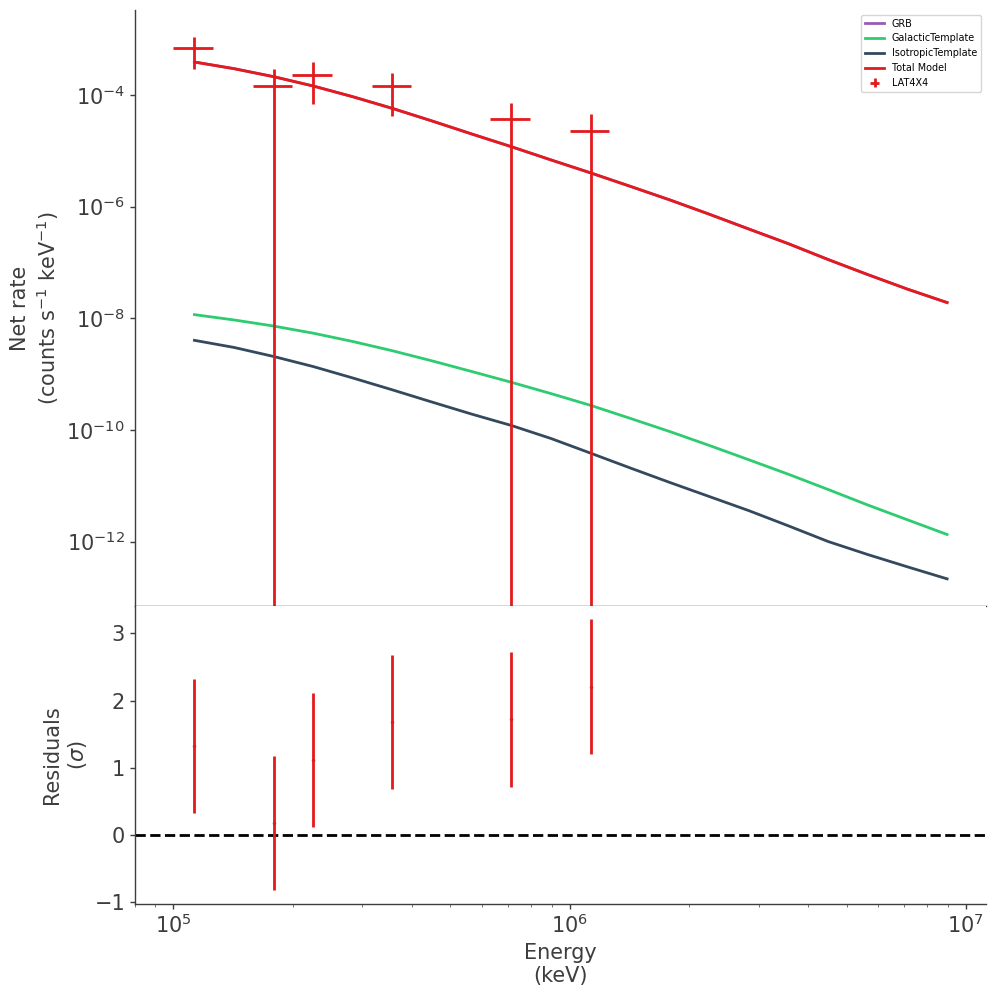

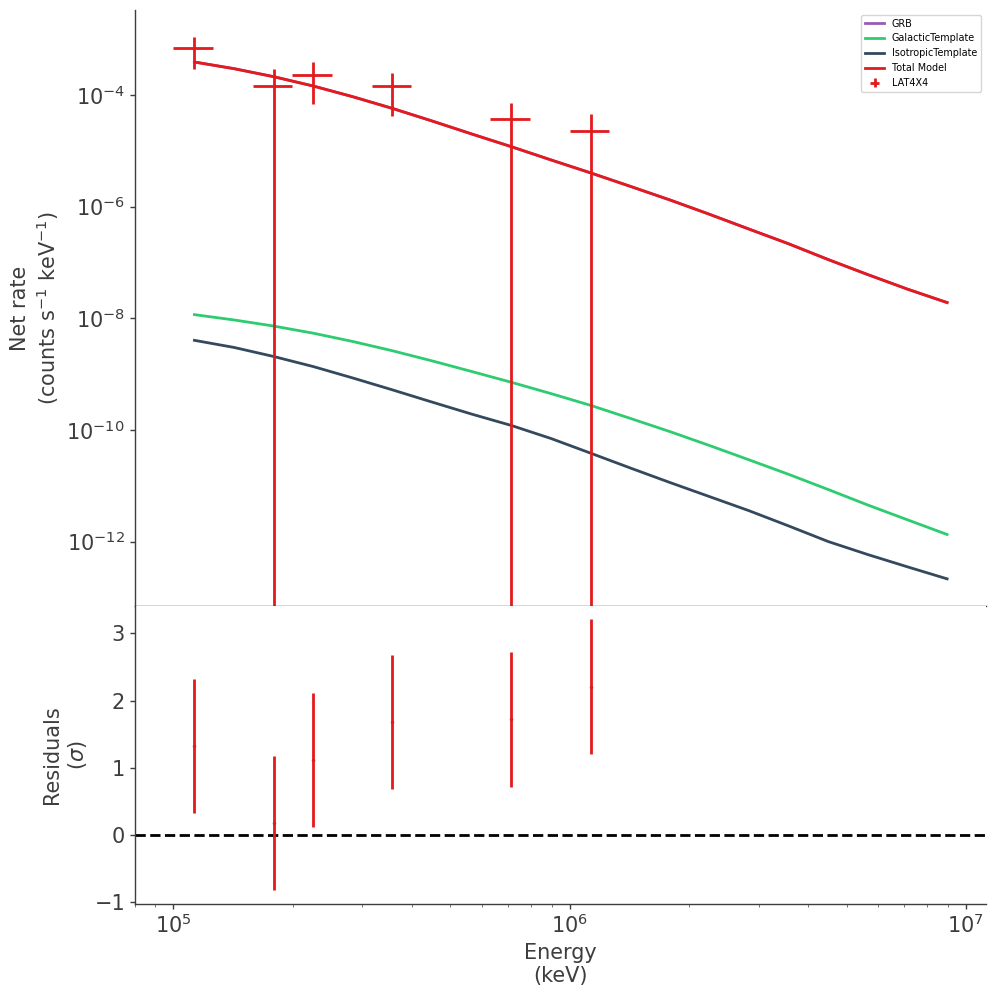

In [16]:
i = 3
T0, T1 = intervals[i], intervals[i + 1]
LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
jl = results[LAT_name]
jl.results.display()
display_spectrum_model_counts(jl, step=False, figsize=(10, 10))

We can see the evolution of the spectrum with time (not all the bins are diplayed):


processing MLE analyses:   0%|          | 0/13 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

06:40:45 DEBUG     converting MeV to MeV                                                          ]8;id=418144;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py\model_plot.py]8;;\:]8;id=853045;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py#890\890]8;;\

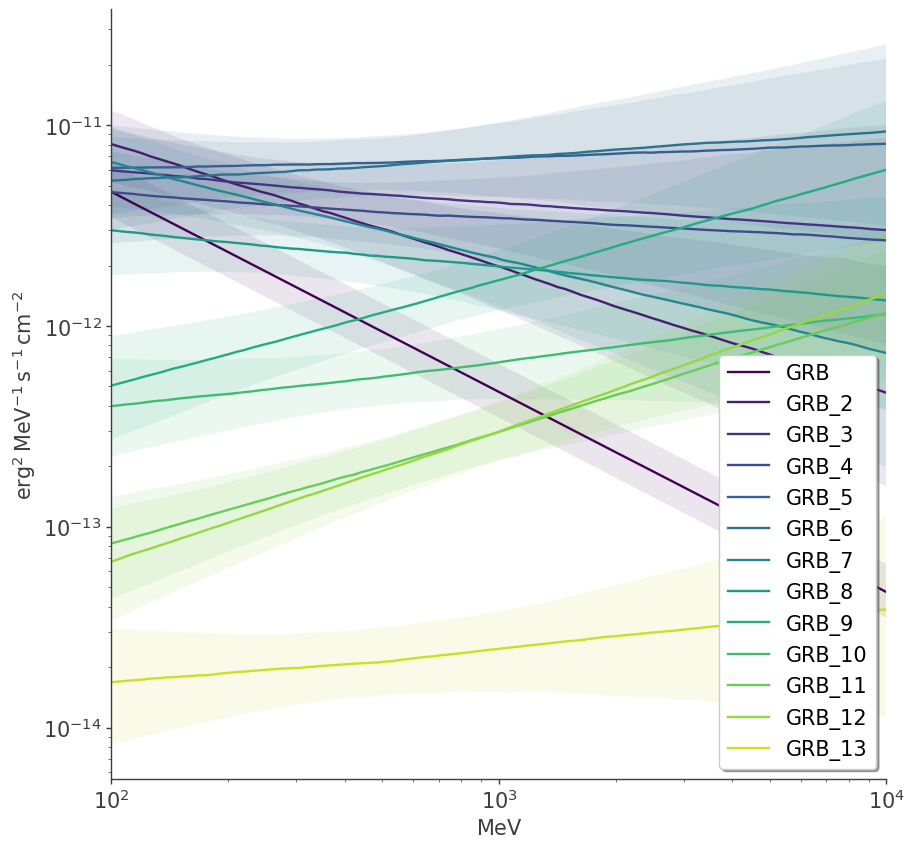

In [17]:
fig = plot_spectra(
    *[results[k].results for k in list(results.keys())[::2]],
    ene_min=100 * u.MeV,
    ene_max=10 * u.GeV,
    flux_unit="erg2/(cm2 s MeV)",
    energy_unit="MeV",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1)
)
fig.set_size_inches(10, 10)

Finally, we can display flux lightcurves and index evolution with time.


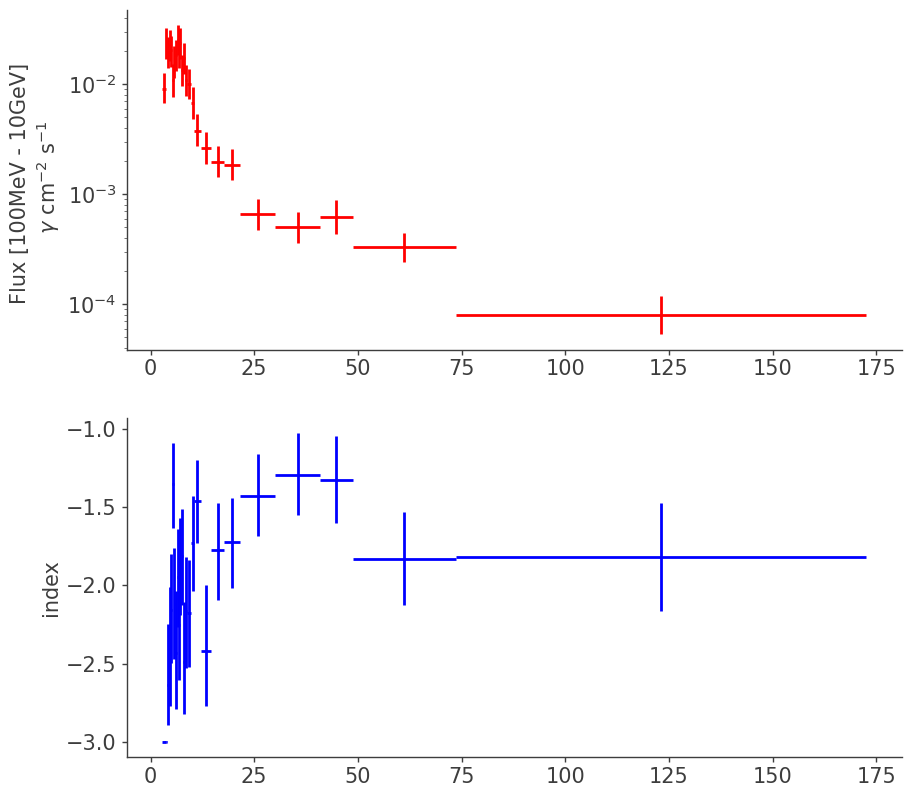

In [18]:
variates = ["F", "index"]
y = {}
for n in variates:
    y[n] = []
    y[n + "_p"] = []
    y[n + "_n"] = []
x = []
dx = []


for T0, T1 in zip(intervals[:-1], intervals[1:]):
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    x.append((T1 + T0) / 2)
    dx.append((T1 - T0) / 2)
    jl = results[LAT_name]
    res = jl.results
    mod = res.optimized_model
    ps = mod.point_sources

    for n in variates:
        my_variate = res.get_variates("GRB.spectrum.main.Powerlaw_flux.%s" % n)
        y[n].append(my_variate.median)
        y[n + "_p"].append(my_variate.equal_tail_interval()[1] - my_variate.median)
        y[n + "_n"].append(my_variate.median - my_variate.equal_tail_interval()[0])
        pass
    pass

fig = plt.figure(figsize=(10, 15))
colors = ["r", "b"]
ylabels = ["Flux [100MeV - 10GeV] \n $\gamma$ cm$^{-2}$ s$^{-1}$", "index"]
for i, n in enumerate(variates):
    plt.subplot(len(variates) + 1, 1, i + 1)
    plt.errorbar(x, y[n], xerr=dx, yerr=(y[n + "_n"], y[n + "_p"]), ls="", c=colors[i])
    if i == 0:
        plt.yscale("log")
    # plt.xscale('log')
    plt.ylabel(ylabels[i])
    pass